In [2]:
import pandas as pd
import geopandas as gpd
import pathlib
import matplotlib.pyplot as plt

/Users/wknq25/opt/anaconda3/envs/geocoder_py38/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/fg/_n1n9v7x7x1bk7m6gwfkv97m0000gp/T/ipykernel_15229/2722465589.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to 

In [48]:
list_of_census = [
    "EW_1851",
    "EW_1861",
    "EW_1881",
    "EW_1891",
    "EW_1901",
    "EW_1911",
    "SCOT_1851",
    "SCOT_1861",
    "SCOT_1871",
    "SCOT_1881",
    "SCOT_1891",
    "SCOT_1901",
]

geom = "os_open_roads"

In [24]:
def set_geom_files(geom_config):
    """Accepts a directory or single filepath and creates a list of file(s)
    containing target geometry data.

    Parameters
    -------

    geom_config: Dataclass
        Dataclass containing parameters for target geometry data.

    Returns
    -------
    geom_files: list
        List containing file(s) of target geometry data.
    """

    geom_files = []
    p = pathlib.Path(geom_config["path_to_geom"])
    if p.is_file():
        geom_files.append(str(p))
    else:
        for file_p in p.iterdir():
            if geom_config["filename_disamb"] in str(file_p):
                geom_files.append(str(file_p))

    return geom_files

def read_shp(filelist, cols_to_keep, geom_config):
    """Reads target geometry from a single shapefile or multiple
    shapefiles. Returns target geometry in geopandas GeoDataFrame.

    Parameters
    ----------

    filelist: list
        List of filepaths.

    cols_to_keep: list
        Columns from target geometry data to read.

    geom_config: Dataclass
        Dataclass containing parameters for target geometry data.

    Returns
    -------
    target_gdf:  geopandas.GeoDataFrame
        Geopandas geodataframe containing target geometry data.
    """
    tmp_file = gpd.read_file(filelist[0], rows=1)
    list_of_all_cols = tmp_file.columns.values.tolist()

    unwanted_cols = [col for col in list_of_all_cols if col not in cols_to_keep]

    target_gdf = gpd.GeoDataFrame(
        pd.concat(
            [
                gpd.read_file(
                    target_shp, ignore_fields=unwanted_cols, crs=geom_config["projection"]
                )
                for target_shp in filelist
            ]
        ),
        crs=geom_config["projection"],
    )
    return target_gdf

In [25]:
geom_config = {
    "path_to_geom": "input/target_geoms/oproad_essh_gb-2/data", 
    "projection": "EPSG:27700",
    "filename_disamb": "RoadLink.shp",
    "data_fields": ["nameTOID", "geometry", "name1"]}

geom_files = set_geom_files(geom_config)
os_open_roads = read_shp(geom_files, geom_config["data_fields"], geom_config)
os_open_roads = os_open_roads.dropna()


In [26]:
os_open_roads = os_open_roads.dissolve(by = "nameTOID", as_index = False)
os_open_roads
# os_open_roads = os_open_roads.reset_index()
# os_open_roads

,nameTOID,geometry,name1
0,osgb4000000003210672,MULTILINESTRING Z ((453879.560 1204073.790 0.0...,Greenbank Road
1,osgb4000000003210673,MULTILINESTRING Z ((463487.510 1211926.630 0.0...,Beach Road
2,osgb4000000003210674,"LINESTRING Z (462006.000 1208921.000 0.000, 46...",Millburn Park
3,osgb4000000003210675,"LINESTRING Z (462127.000 1209485.000 0.000, 46...",Cormorant Way
4,osgb4000000003210676,MULTILINESTRING Z ((459970.480 1200649.850 0.0...,Brucehall Terrace
...,...,...,...
794633,osgb5000005276067656,MULTILINESTRING Z ((463147.680 154315.140 0.00...,Bloxham Close
794634,osgb5000005276068545,"LINESTRING Z (567915.090 277945.740 0.000, 567...",Mias Way
794635,osgb5000005276069028,MULTILINESTRING Z ((356379.850 406641.610 0.00...,Entwistle Green
794636,osgb5000005276069030,MULTILINESTRING Z ((356508.940 406520.350 0.00...,Carnet Close


In [56]:
gdf_concat_list = []
# os_open_roads_lnk = os_open_roads.copy()

ew_roads = os_open_roads.copy()
scot_roads = os_open_roads.copy()


for iter, census in enumerate(list_of_census):
	country = census.split("_")[0]
	year = census.split("_")[1]
	print(country, year, iter, len(ew_roads), len(scot_roads))
	geom_all = pd.read_csv(f"analysis/{year}/{country}/{geom}/{geom}_link_lkup_merge.tsv", sep = "\t", usecols = [f"{geom}_{country}_{year}"])
	# geom_all = geom_all.rename(columns = {"RecID":f"RecID_{country}_{year}"})
	geom_all = geom_all.dropna()


	geom_all[f"{geom}_id"] = geom_all[f"{geom}_{country}_{year}"].str.split("_").str[0]
	geom_all = geom_all.drop(columns=f"{geom}_{country}_{year}")
	geom_all = geom_all.groupby("os_open_roads_id").size().reset_index(name = f"{country}_{year}")

	# print(geom_all)
# 	# if iter == 0:
	if country == "EW":
		ew_roads = pd.merge(left = ew_roads, right = geom_all, left_on = "nameTOID", right_on = "os_open_roads_id", how = "left").drop("os_open_roads_id", axis=1)
	else:
		scot_roads = pd.merge(left = scot_roads, right = geom_all, left_on = "nameTOID", right_on = "os_open_roads_id", how = "left").drop("os_open_roads_id", axis=1)
	# print(os_open_roads_lnk)
# 		# print(geom_merged)
# 		# print(os_open_roads)
# 	# else:

# 	# 	geom_merged = pd.merge(left = geom_merged, right = geom_all, left_on = "nameTOID", right_on = "os_open_roads_id", how = "left").drop("os_open_roads_id", axis=1)
# 		# print(geom_merged)
# 	# gdf_concat_list.append(geom_merged)



EW 1851 0 794638 794638
EW 1861 1 794638 794638
EW 1881 2 794638 794638
EW 1891 3 794638 794638
EW 1901 4 794638 794638
EW 1911 5 794638 794638
SCOT 1851 6 794638 794638
SCOT 1861 7 794638 794638
SCOT 1871 8 794638 794638
SCOT 1881 9 794638 794638
SCOT 1891 10 794638 794638
SCOT 1901 11 794638 794638


In [54]:
# final = final.dropna()
final[final["EW_1851"].isna() == False]

,nameTOID,geometry,name1,EW_1851,EW_1861,EW_1881,EW_1891,EW_1901,EW_1911,SCOT_1851,SCOT_1861,SCOT_1871,SCOT_1881,SCOT_1891,SCOT_1901
51571,osgb4000000006295135,MULTILINESTRING Z ((378191.360 603573.690 0.00...,Cottonshope Road,14.0,26.0,12.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51581,osgb4000000006295145,MULTILINESTRING Z ((382718.450 601490.560 0.00...,Bushman's Road,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51651,osgb4000000006295223,MULTILINESTRING Z ((394582.380 647754.170 0.00...,Shoreswood Loan,9.0,74.0,38.0,NaN,85.0,138.0,NaN,NaN,NaN,NaN,NaN,NaN
51803,osgb4000000006295380,MULTILINESTRING Z ((399384.000 653747.000 0.00...,North Road,6.0,10.0,NaN,NaN,1.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
52686,osgb4000000006296304,MULTILINESTRING Z ((398546.000 627833.000 0.00...,Common Road,6.0,NaN,NaN,30.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794477,osgb5000005275772405,MULTILINESTRING Z ((592366.620 120322.130 0.00...,Rock Channel (East),20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794500,osgb5000005275812370,"LINESTRING Z (213154.440 200326.050 0.000, 213...",Cottage Mews,6.0,7.0,7.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794562,osgb5000005275932301,"LINESTRING Z (528397.740 116933.770 0.000, 528...",Diplocks Mews,6.0,NaN,5.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
794594,osgb5000005275991881,"LINESTRING Z (583644.300 200489.750 0.000, 583...",Great Canney Court,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
test = ew_roads.dropna().copy()
test

,nameTOID,geometry,name1,EW_1851,EW_1861,EW_1881,EW_1891,EW_1901,EW_1911
52688,osgb4000000006296306,MULTILINESTRING Z ((399103.590 627978.190 0.00...,Ramsey Lane,161.0,196.0,98.0,116.0,104.0,123.0
52691,osgb4000000006296309,MULTILINESTRING Z ((399213.000 628100.000 0.00...,Tenter Hill,116.0,94.0,132.0,104.0,79.0,59.0
52695,osgb4000000006296313,MULTILINESTRING Z ((399124.000 628471.000 0.00...,Ryecroft Way,8.0,12.0,5.0,10.0,9.0,27.0
54377,osgb4000000006298026,MULTILINESTRING Z ((399875.600 652920.700 0.00...,Marygate,739.0,627.0,491.0,465.0,155.0,19.0
54378,osgb4000000006298027,MULTILINESTRING Z ((399727.140 653043.060 0.00...,Walkergate,474.0,465.0,406.0,389.0,336.0,367.0
...,...,...,...,...,...,...,...,...,...
791849,osgb5000005268850957,"LINESTRING Z (419689.910 410934.750 0.000, 419...",Bank Side,47.0,68.0,62.0,152.0,56.0,105.0
792886,osgb5000005271423246,MULTILINESTRING Z ((623285.000 308630.000 0.00...,Bank Plain,64.0,71.0,45.0,29.0,2.0,8.0
793317,osgb5000005272507747,MULTILINESTRING Z ((455262.440 515924.500 0.00...,Upsall Grange Gardens,31.0,13.0,21.0,20.0,9.0,19.0
793767,osgb5000005273545143,"LINESTRING Z (372704.320 442073.330 0.000, 372...",Shireburn Fold,41.0,3.0,11.0,8.0,39.0,30.0


In [58]:
test2 = scot_roads.dropna().copy()
test2

,nameTOID,geometry,name1,SCOT_1851,SCOT_1861,SCOT_1871,SCOT_1881,SCOT_1891,SCOT_1901
29,osgb4000000003222271,MULTILINESTRING Z ((440328.000 1139636.000 0.0...,Berry Road,8.0,12.0,9.0,16.0,15.0,9.0
39,osgb4000000003222281,MULTILINESTRING Z ((447593.000 1141620.000 0.0...,Commercial Street,601.0,593.0,401.0,376.0,375.0,364.0
46,osgb4000000003222288,MULTILINESTRING Z ((447482.000 1141371.000 0.0...,Hillhead,17.0,52.0,38.0,45.0,54.0,108.0
133,osgb4000000003222375,"LINESTRING Z (446550.810 1140518.440 0.000, 44...",Kantersted Court,15.0,19.0,12.0,4.0,19.0,41.0
151,osgb4000000003222395,"LINESTRING Z (447697.030 1141267.070 0.000, 44...",Mounthooly Street,69.0,136.0,134.0,136.0,77.0,111.0
...,...,...,...,...,...,...,...,...,...
791317,osgb5000005267393461,"LINESTRING Z (272359.600 668910.850 0.000, 272...",Farm Lane,149.0,227.0,227.0,116.0,285.0,198.0
791352,osgb5000005267531359,"LINESTRING Z (392644.480 847975.520 0.000, 392...",Old Mill Lane,48.0,66.0,108.0,33.0,13.0,33.0
791666,osgb5000005268327900,"LINESTRING Z (254936.600 622073.380 0.000, 254...",The Old School Yard,208.0,8.0,15.0,50.0,76.0,34.0
791831,osgb5000005268822428,"LINESTRING Z (333157.250 636903.930 0.000, 333...",Caerlee Mill,6.0,30.0,138.0,246.0,143.0,83.0


In [61]:
test_all = pd.concat([test, test2])
test_all

,nameTOID,geometry,name1,EW_1851,EW_1861,EW_1881,EW_1891,EW_1901,EW_1911,SCOT_1851,SCOT_1861,SCOT_1871,SCOT_1881,SCOT_1891,SCOT_1901
52688,osgb4000000006296306,MULTILINESTRING Z ((399103.590 627978.190 0.00...,Ramsey Lane,161.0,196.0,98.0,116.0,104.0,123.0,NaN,NaN,NaN,NaN,NaN,NaN
52691,osgb4000000006296309,MULTILINESTRING Z ((399213.000 628100.000 0.00...,Tenter Hill,116.0,94.0,132.0,104.0,79.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN
52695,osgb4000000006296313,MULTILINESTRING Z ((399124.000 628471.000 0.00...,Ryecroft Way,8.0,12.0,5.0,10.0,9.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN
54377,osgb4000000006298026,MULTILINESTRING Z ((399875.600 652920.700 0.00...,Marygate,739.0,627.0,491.0,465.0,155.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN
54378,osgb4000000006298027,MULTILINESTRING Z ((399727.140 653043.060 0.00...,Walkergate,474.0,465.0,406.0,389.0,336.0,367.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791317,osgb5000005267393461,"LINESTRING Z (272359.600 668910.850 0.000, 272...",Farm Lane,NaN,NaN,NaN,NaN,NaN,NaN,149.0,227.0,227.0,116.0,285.0,198.0
791352,osgb5000005267531359,"LINESTRING Z (392644.480 847975.520 0.000, 392...",Old Mill Lane,NaN,NaN,NaN,NaN,NaN,NaN,48.0,66.0,108.0,33.0,13.0,33.0
791666,osgb5000005268327900,"LINESTRING Z (254936.600 622073.380 0.000, 254...",The Old School Yard,NaN,NaN,NaN,NaN,NaN,NaN,208.0,8.0,15.0,50.0,76.0,34.0
791831,osgb5000005268822428,"LINESTRING Z (333157.250 636903.930 0.000, 333...",Caerlee Mill,NaN,NaN,NaN,NaN,NaN,NaN,6.0,30.0,138.0,246.0,143.0,83.0


NameError: name 'test_all' is not defined

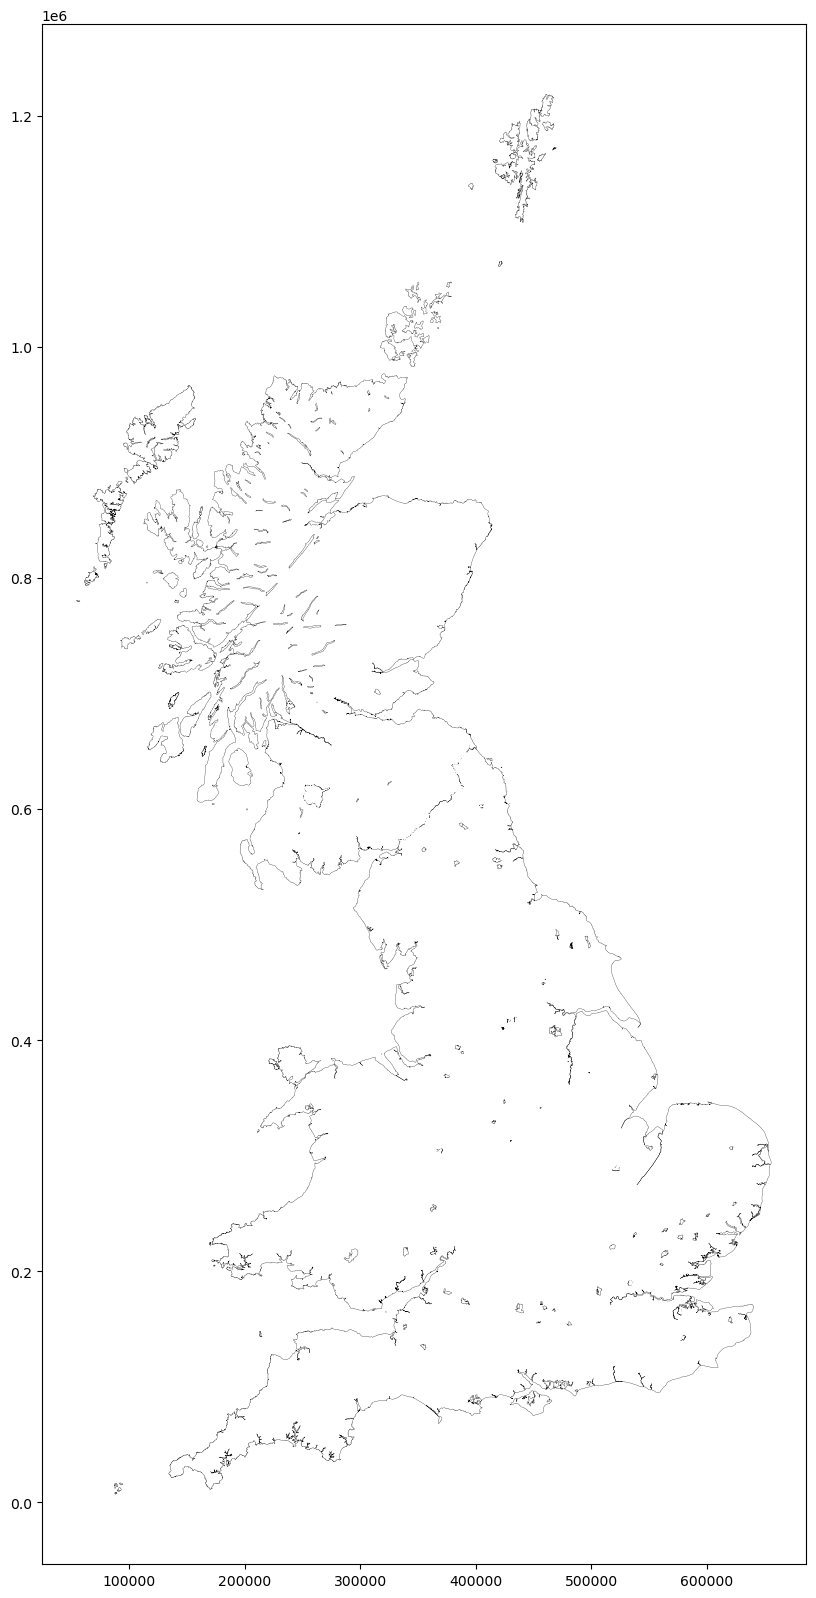

In [3]:
gb_outline = gpd.read_file("analysis/GB_outline_boundary.geojson")
cities = gpd.read_file("analysis/major_cities.geojson")
base = gb_outline.plot(color='white', edgecolor='black',linewidth=0.2, figsize=(20,20), zorder=0)
test_all.plot(ax = base, linewidth = 0.3, zorder = 1)
testing = cities.plot(ax = base, marker = "s", color = "black", zorder = 2, markersize=5)
testing.axis("off")
testing.set_title("Streets linked over time in Britain 1851-1911")


# plt.annotate(s=cities['place_name'], xy=[row['latitude'],row['longitude']])
for label, x, y in zip(cities['place_name'], cities["geometry"].x, cities["geometry"].y):
    # ax1.annotate(label, xy = (x + 0.008, y - 0.003),fontsize = 15)
    testing.annotate(text = label, xy = (x,y), xytext = (x+5000,y+2500))
plt.tight_layout()
plt.savefig('persistent_streets.png', dpi=1000)